**I think we can start here with preprocessing and building up a pipeline for classifying with a traditional model from pose estimation**

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Claases

- Walking
- Standing
- Fast walking / jogging?
- Running

In [ ]:
# import kagglehub
# Download latest version from kagglehub:

import kagglehub

# Download latest version

path = kagglehub.dataset_download("easonlll/hmdb51")


print("Path to dataset files:", path)

Using Colab cache for faster access to the 'hmdb51' dataset.
Path to dataset files: /kaggle/input/hmdb51


# Mount to my Drive

I'm just doing this here because I got tired of downloading the data again and again each time the runtime environment resets.

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, applications
import random
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam



# Dataset and training configuration
DATASET_PATH = path + "/HMDB51"
TARGET_CLASSES = ["run", "walk", "stand"]
FRAME_COUNT = 16
IMAGE_SIZE = (160, 160) # Why this size? not sure
BATCH_SIZE = 8

# Define generator

In [ ]:
class VideoSequenceGenerator(tf.keras.utils.Sequence):
    """
    Generates batches of videos for training.
    Handles short videos via last-frame padding.
    Returns integer labels (sparse) for sparse_categorical_crossentropy.
    """
    def __init__(self, sample_paths, labels, batch_size=8, frame_count=16, image_size=(160,160), shuffle=True):
        self.sample_paths = sample_paths
        self.labels = labels
        self.batch_size = batch_size
        self.frame_count = frame_count
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.sample_paths))
        self.on_epoch_end()

    def __len__(self):
        # number of batches per epoch
        return int(np.ceil(len(self.sample_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = np.zeros((len(batch_indexes), self.frame_count, *self.image_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_indexes),), dtype=np.int32)

        for i, idx in enumerate(batch_indexes):
            video_path = self.sample_paths[idx]
            frames = sorted([f for f in os.listdir(video_path) if f.lower().endswith(('.jpg'))])

            selected = []
            while len(selected) < self.frame_count and len(frames) > 0:
                selected += frames
            selected = selected[:self.frame_count]

            # load frames
            video_frames = []
            for fname in selected:
                img = cv2.imread(os.path.join(video_path, fname))
                img = cv2.resize(img, self.image_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = tf.keras.applications.efficientnet.preprocess_input(img)
                video_frames.append(img)

            video_frames = np.array(video_frames, dtype=np.float32)

            # pad if too short
            if len(video_frames) < self.frame_count:
                last_frame = video_frames[-1] if len(video_frames)>0 else np.zeros((*self.image_size,3))
                missing = self.frame_count - len(video_frames)
                pad = np.repeat(last_frame[np.newaxis, ...], missing, axis=0)
                video_frames = np.concatenate([video_frames, pad], axis=0)

            X[i] = video_frames
            y[i] = self.labels[idx]

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


# Data discovery

In [ ]:
# --- STEP: DATASET SCANNING / GATHERING PATHS & LABELS ---
def gather_sample_dirs(dataset_root, target_classes):
    """
    Scans the dataset directory and returns lists of sample folders and their labels.

    Args:
        dataset_root (str): Root path to dataset (contains folders for each class)
        target_classes (list of str): Classes to include, e.g., ["run", "walk", "stand"]

    Returns:
        sample_paths (np.array): Paths to each video folder
        sample_labels (np.array): Integer labels corresponding to classes
    """
    sample_paths = []
    sample_labels = []
    class_map = {cls: i for i, cls in enumerate(target_classes)}

    print(f"Scanning directory: {dataset_root}")

    for class_name in target_classes:
        class_dir = os.path.join(dataset_root, class_name)

        if not os.path.isdir(class_dir):
            print(f"Warning: Class folder '{class_name}' NOT found at {class_dir}")
            continue

        label_id = class_map[class_name]

        # Every video is stored as a folder of frames
        for video_folder in os.listdir(class_dir):
            video_path = os.path.join(class_dir, video_folder)
            if os.path.isdir(video_path):
                sample_paths.append(video_path)
                sample_labels.append(label_id)

    sample_paths = np.array(sample_paths)
    sample_labels = np.array(sample_labels)

    print(f"\n--- RESULTS ---")
    print(f"Total samples found: {len(sample_paths)}")
    if len(sample_paths) > 0:
        print(f"Example path: {sample_paths[0]}")
        print(f"Example label: {sample_labels[0]} ({target_classes[sample_labels[0]]})")

    return sample_paths, sample_labels


# --- EXECUTE THE SCAN ---
X_all, y_all = gather_sample_dirs(DATASET_PATH, TARGET_CLASSES)


Scanning directory: /kaggle/input/hmdb51/HMDB51

--- RESULTS ---
Total samples found: 934
Example path: /kaggle/input/hmdb51/HMDB51/run/THE_PROTECTOR_run_f_cm_np1_le_med_42
Example label: 0 (run)


# Train test split

In [ ]:
from sklearn.model_selection import train_test_split

# I just set some random number for the random state, 4! so we can reproduce our findings (to some extent)
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=4)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")


Training samples: 747
Validation samples: 187


# Initialize generator and check shape

In [ ]:
# Initialize
train_gen = VideoSequenceGenerator(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    frame_count=FRAME_COUNT,
    image_size=IMAGE_SIZE  # <- pass a tuple (height, width)
)

val_gen = VideoSequenceGenerator(
    X_val,
    y_val,
    batch_size=BATCH_SIZE,
    frame_count=FRAME_COUNT,
    image_size=IMAGE_SIZE
)

# --- DEBUG CHECK ---
# Grab the first batch to verify shapes
try:
    X_sample, y_sample = train_gen.__getitem__(0)
    print("Generator Check Passed!")
    print(f"Input Shape (Batch, Frames, H, W, Ch): {X_sample.shape}")
    print(f"Labels Shape: {y_sample.shape}")
except Exception as e:
    print(f"Generator Failed: {e}")

Generator Check Passed!
Input Shape (Batch, Frames, H, W, Ch): (8, 16, 160, 160, 3)
Labels Shape: (8,)


# Wrap Generators as tf.data.Dataset

In [ ]:
def convert_to_tf_dataset(generator):
    """
    Wraps a Keras Sequence into a tf.data.Dataset that repeats indefinitely.
    """
    def gen():
        for i in range(len(generator)):
            yield generator[i]

    output_signature = (
        tf.TensorSpec(shape=(None, FRAME_COUNT, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )

    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    ds = ds.repeat()  # repeat indefinitely for fit()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [ ]:
train_ds = convert_to_tf_dataset(train_gen)
val_ds   = convert_to_tf_dataset(val_gen)


# Model build (pre-trained efficientnet)

In [ ]:
def build_tunable_model():
    video_input = layers.Input(shape=(FRAME_COUNT, *IMAGE_SIZE, 3))
    base_cnn = applications.EfficientNetB0(
        weights='imagenet', # pre-trained on the imagenet dataset
        include_top=False, # removes the ImageNet classifier head
        input_shape=(*IMAGE_SIZE, 3)
    )

    # fine-tune top 20 layers
    base_cnn.trainable = True
    for layer in base_cnn.layers[:-20]:
        layer.trainable = False

    encoded_frames = layers.TimeDistributed(base_cnn)(video_input) # Applying CNN to each frame independently
    encoded_frames = layers.TimeDistributed(layers.GlobalAveragePooling2D())(encoded_frames) # Each frame is now summarized as a single feature vector
    video_summary = layers.GlobalAveragePooling1D()(encoded_frames) # Averages features across all frames, becomes (batch_size, C')

    output = layers.Dense(len(TARGET_CLASSES), activation='softmax')(video_summary)
    model = models.Model(inputs=video_input, outputs=output)
    model.compile(
        optimizer=Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_tunable_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 16, 160, 160,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 5, 5, 1280) │     4,049,571 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 1,354,803 (5.17 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

# Train the model on our classes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Drive

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Ensure the folder exists
os.makedirs("/content/drive/MyDrive/Models", exist_ok=True)

train_steps = len(train_gen)
val_steps = len(val_gen)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint("/content/drive/MyDrive/Models/hmdb51_efficientnet_best.keras",
                    monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks
)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 832s 6s/step - accuracy: 0.5201 - loss: 0.9645 - val_accuracy: 0.6631 - val_loss: 0.7850
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 551s 6s/step - accuracy: 0.7489 - loss: 0.6353 - val_accuracy: 0.6952 - val_loss: 0.7371
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 623s 7s/step - accuracy: 0.8069 - loss: 0.5030 - val_accuracy: 0.7112 - val_loss: 0.7207
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 560s 6s/step - accuracy: 0.8881 - loss: 0.3960 - val_accuracy: 0.7059 - val_loss: 0.7289
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 561s 6s/step - accuracy: 0.9323 - loss: 0.3086 - val_accuracy: 0.7005 - val_loss: 0.7520
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 544s 6s/step - accuracy: 0.9595 - loss: 0.2326 - val_accuracy: 0.6845 - val_loss: 0.7903
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 553s 6s/step - accuracy: 0.9838 - loss: 0.1686 - val_accuracy: 0.6845 -

# Save the model to google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mv /content/hmdb51_efficientnet.keras /content/drive/MyDrive/



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mv: cannot stat '/content/hmdb51_efficientnet.h5': No such file or directory


In [ ]:
from tensorflow.keras.models import load_model
from google.colab import drive

drive.mount('/content/drive')
model = load_model("/content/drive/MyDrive/hmdb51_efficientnet.h5")


6/6 ━━━━━━━━━━━━━━━━━━━━ 203s 26s/step
Confusion Matrix:
 [[30 14  2]
 [18 86  6]
 [ 3 11 17]]


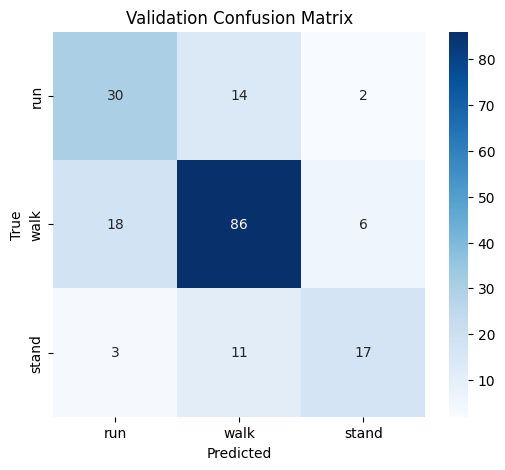

              precision    recall  f1-score   support

         run       0.59      0.65      0.62        46
        walk       0.77      0.78      0.78       110
       stand       0.68      0.55      0.61        31

    accuracy                           0.71       187
   macro avg       0.68      0.66      0.67       187
weighted avg       0.71      0.71      0.71       187



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. Preload all validation videos into memory ---
X_val_all = []
y_val_all = []

for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]
    X_val_all.append(X_batch)
    y_val_all.append(y_batch)

X_val_all = np.concatenate(X_val_all, axis=0)
y_val_all = np.concatenate(y_val_all, axis=0)

# --- 2. Predict all at once ---
preds = model.predict(X_val_all, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = y_val_all

# --- 3. Confusion matrix ---
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Optional nicer display
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=TARGET_CLASSES, yticklabels=TARGET_CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=TARGET_CLASSES))
